In [1]:
import numpy as np
import matplotlib.pyplot as plt
import client_moodle as server
import random
%matplotlib inline

In [2]:
# constants
TEAM_ID = 'dGtgGZhUiTAytVHtKMwFEbEBZl9vcBwrsP5rOSTTrLQuOsDAY2'

GENE_MIN = -10
GENE_MAX = 10

CHROMOSOME_SIZE = 11
POPULATION_SIZE = 8 # Keep power of 2

# GAUSS_NOISE_MEAN = 0.0
# GAUSS_NOISE_STD = 1

MUTATE_PROB = 0.3

NUM_GENERATIONS = 80

In [3]:
INITIAL_WEIGHTS =[-6.91707159e-13,  1.42310080e-01, -8.57642411e+00,  6.02740569e-02,4.57275757e-02,  1.25113374e-04, -7.35443216e-05, -2.06094947e-07,4.42275928e-08,  6.63375543e-11, -8.78324242e-12]
len(INITIAL_WEIGHTS)

11

In [4]:
class Darwin:
    '''
    This class encapsulates a genetic algorithm runner over population consisting of weight vectors
    '''

    def __init__(self, val: list):
        if len(val) != POPULATION_SIZE:
            raise ValueError

        self.population = np.array(val, dtype=np.double)
        self.weight_fitness_map = [] # consists of tuples (vector,fitness) for all generations
        self.best_fit = []  # stores best_fit for each of the generation used for plotting
        

    def Sort_Tuple(self, tup):
        tup.sort(key = lambda x: x[1],reverse = True)  
        return tup  
        
    def get_fitness(self):
        
        # try changing this error_to_fitness function
        def error_to_fitness(train_err, valid_err):
            return 1/(train_err + 5*valid_err)
        
        fitness = []
        weight_fit_map = []
        for chrom in self.population:
            
            train_err, valid_err = server.get_errors(TEAM_ID, list(chrom))
            fit = error_to_fitness(train_err, valid_err)
                
            fitness.append(fit)
            weight_fit_map.append((chrom,fit))
            self.weight_fitness_map.append((chrom,fit,valid_err,train_err)) # this adds a tuple to this list
        
        weight_fit_map = self.Sort_Tuple(weight_fit_map)
        
        fitness = np.array(fitness, dtype=np.double)
        return fitness, weight_fit_map

    @classmethod
    def crossover(self, mom: np.ndarray, dad: np.ndarray):
        '''
        Generates offsprings out of the two parents
        '''

        def random_prefix(mom: np.ndarray, dad: np.ndarray):
            '''
            Random prefixes and suffixes
            '''
            thresh = np.random.randint(CHROMOSOME_SIZE) # index

            alice = np.copy(dad) # mom mom dad
            bob = np.copy(mom) # dad dad mom

            alice[0:thresh] = mom[0:thresh]
            bob[0:thresh] = dad[0:thresh]

            return alice, bob

        return random_prefix(mom, dad)
    
    def normal_crossover(self, mom: np.ndarray, dad:np.ndarray):
        thresh = np.random.randint(CHROMOSOME_SIZE)
        child = np.copy(dad)
        child[0:thresh] = mom[0:thresh]
        return child

    @classmethod
    def mutate(self, population: np.ndarray):
        '''
        Mutates the population randomly
        '''
        
        def add_gauss_noise(population: np.ndarray):
            '''
            Adds a gaussian noise to some of the elements
            '''
            means = np.mean(population, axis=0) # mean of each gene across the population - to keep mutations of level
            
            # TODO: vectorise
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    noise = np.random.normal(loc=means[idx[1]]/10, scale=abs(means[idx[1]])/10)
                    population[idx] += noise

            return np.clip(population, GENE_MIN, GENE_MAX)
        
        def add_uniform_noise(population: np.ndarray):
            
            means = np.mean(population, axis=0)
            delta = means/20                   # to get the five percent of it
            
            for weights in population:
                # add or subtract 5 percent of the mean
                guess = random.randint(0,2)
                noise = np.random.uniform(0,delta)
                
                if guess == 1:
                    # add the uniformly generated noise
                    weights = weights + noise
                else:
                    # subtract the uniformly generated noi
                    weights = weights - noise
            return np.clip(population, GENE_MIN, GENE_MAX)
        
        return add_gauss_noise(population)


    def breed(self):
        '''
        Creates the next generation
        '''

        def russian_roulette():
            '''
            Whenever a parent is required, one is selected with probability proportional to fitness
            '''

            def get_parent_index(thresholds):
                draw = np.random.random() # in [0, 1)

                for i in range(len(thresholds)):
                    if draw < thresholds[i]:
                        return i
                return len(thresholds) - 1    
            
            fitness, weight_fit_map = self.get_fitness()
            self.best_fit.append(weight_fit_map[0][1])       # adds the best weight vector for this generation
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]

            thresholds = []
            thresh = 0.0
            fitness_sum = np.sum(normalized_fitness)
            for val in normalized_fitness:
                thresh = thresh + (val/fitness_sum)
                thresholds.append(thresh)

            offsprings = []
            for i in range(int(POPULATION_SIZE / 2)):
                mom = self.population[get_parent_index(thresholds)]
                dad = self.population[get_parent_index(thresholds)]

                alice, bob = self.crossover(mom, dad)
                offsprings.append(alice)
                offsprings.append(bob)
            offsprings = np.array(offsprings, dtype=np.double)
            self.population = self.mutate(offsprings)
        
        def normal_breed():
            fitness, weight_fit_map = self.get_fitness()
            self.best_fit.append(weight_fit_map[0][1])       # adds the best weight vector for this generation
            
            offsprings = []
            for i in range(4):
                for j in range(i+1,4):
                    mom = weight_fit_map[i][0]
                    dad = weight_fit_map[j][0]
                    
                    alice = self.normal_crossover(mom,dad)
                    offsprings.append(alice)
                    
            assert len(offsprings) == 6
            offsprings.append(weight_fit_map[0][0])
            offsprings.append(weight_fit_map[1][0])
            offsprings = np.array(offsprings, dtype=np.double)
            temp = self.mutate(offsprings)
            temp[POPULATION_SIZE-1] = weight_fit_map[0][0]   # this adds the best from the previous population
            temp[POPULATION_SIZE-2] = weight_fit_map[1][0]
            self.population = temp
        
#         normal_breed()
        russian_roulette()
        
    
    def train(self):

        for i in range(NUM_GENERATIONS):
            self.breed()
        
        # haven't calculated the fitness of the final population
        fitness, weight_fit_map = self.get_fitness()
        self.best_fit.append(weight_fit_map[0][1])
        
        plt.plot(self.best_fit)
        plt.xlabel('Generations', fontsize=12)
        plt.ylabel('Best Fitness', fontsize=12)
        plt.title('Best Fitness across Generations', fontsize=14)
        plt.show()
        
        # calculate the best eight vectors
        self.weight_fitness_map = self.Sort_Tuple(self.weight_fitness_map)
        next_parents = np.array(self.weight_fitness_map)
        next_parents = next_parents[0:8]  # getting all the weight vectors
        return next_parents,self.weight_fitness_map[0]


In [5]:
initial_vector = [
    [-6.91707159e-13,  1.42310080e-01, -8.57642411e+00,  6.02740569e-02,
     4.57275757e-02,  1.25113374e-04, -7.35443216e-05, -2.06094947e-07,
     4.42275928e-08,  6.63375543e-11, -8.78324242e-12],
    [-7.11707159e-13,  2.02310080e-01, -8.57642411e+00,  6.10740569e-02,
     4.57275757e-02,  1.25113374e-04, -6.35443216e-05, -2.03094947e-07,
     4.42275928e-08,  6.63375543e-11, -8.78324242e-12],
    [-5.91707159e-13,  1.42310080e-01, -8.57642411e+00,  6.02740569e-02,
     4.57275757e-02,  1.25113374e-04, -7.35443216e-05, -1.86094947e-07,
     4.22275928e-08,  6.53365543e-11, -9.38324242e-12],
    [-6.91707159e-13,  1.52610080e-01, -9.57642411e+00,  6.02740569e-02,
     4.57275757e-02,  1.16713374e-04, -7.35443216e-05, -2.06094947e-07,
     4.42275928e-08,  6.63375543e-11, -8.78324242e-12],
    [-6.91705099e-13,  1.42310080e-01, -8.57642411e+00,  6.12740569e-02,
     5.57275757e-02,  1.25113374e-04, -7.25443216e-05, -2.06094947e-07,
     4.47775928e-08,  6.63375543e-11, -8.78324242e-12],
    [-6.91707159e-13,  1.12310080e-01, -8.57642411e+00,  6.32740569e-02,
     4.57275757e-02,  0.85113374e-04, -7.35443216e-05, -2.28094947e-07,
     4.42274088e-08,  6.63375543e-11, -7.9324242e-12],
    [-6.93457159e-13,  1.42310080e-01, -8.57642411e+00,  6.02740569e-02,
     4.57275757e-02,  0.95113374e-04, -7.35443216e-05, -2.06094947e-07,
     4.42275928e-08,  6.63375543e-11, -8.78324242e-12],
    [-6.71707159e-13,  1.29560080e-01, -8.57642411e+00,  5.8176569e-02,
     4.67856757e-02,  1.00013374e-04, -6.95443216e-05, -2.06094947e-07,
     4.244575928e-08,  7.000075543e-11, -8.78324242e-12],
]

In [6]:
darwin = Darwin(initial_vector)
darwin.population[0]

array([-6.91707159e-13,  1.42310080e-01, -8.57642411e+00,  6.02740569e-02,
        4.57275757e-02,  1.25113374e-04, -7.35443216e-05, -2.06094947e-07,
        4.42275928e-08,  6.63375543e-11, -8.78324242e-12])

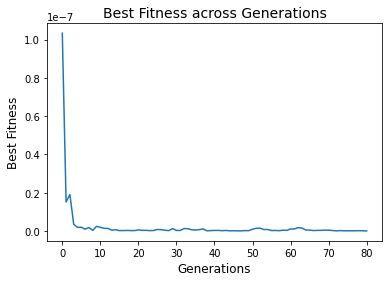

In [7]:
next_parents,best_pair = darwin.train()

In [8]:
best_fitness = best_pair[1]
print(best_fitness)

1.0329449759961564e-07


In [9]:
best_chromosome = best_pair[0]
print(best_chromosome)

[-6.91707159e-13  1.42310080e-01 -8.57642411e+00  6.02740569e-02
  4.57275757e-02  1.25113374e-04 -7.35443216e-05 -2.06094947e-07
  4.42275928e-08  6.63375543e-11 -8.78324242e-12]


In [10]:
for parent in next_parents:
    print('Vector')
    print(parent[0])
    print('Fitness:', parent[1])
    print('Train:', parent[2], 'Val:', parent[3])
    print('')

Vector
[-6.91707159e-13  1.42310080e-01 -8.57642411e+00  6.02740569e-02
  4.57275757e-02  1.25113374e-04 -7.35443216e-05 -2.06094947e-07
  4.42275928e-08  6.63375543e-11 -8.78324242e-12]
Fitness: 1.0329449759961564e-07
Train: 1086281.3341038285 Val: 4249651.113179501

Vector
[-6.91707159e-13  1.52610080e-01 -9.57642411e+00  6.02740569e-02
  4.57275757e-02  1.16713374e-04 -7.35443216e-05 -2.06094947e-07
  4.42275928e-08  6.63375543e-11 -8.78324242e-12]
Fitness: 3.361013528187294e-08
Train: 4933945.701652662 Val: 5083201.422350008

Vector
[-6.91707159e-13  1.45396240e-01 -8.57642411e+00  6.02740569e-02
  4.57275757e-02  1.45430362e-04 -7.35443216e-05 -2.06094947e-07
  4.42275928e-08  6.63375543e-11 -8.78324242e-12]
Fitness: 1.9055365557085646e-08
Train: 9451038.336650703 Val: 5223465.679903443

Vector
[-6.91707159e-13  1.49291803e-01 -8.57642411e+00  7.14137075e-02
  5.04957223e-02  1.16713374e-04 -7.53457211e-05 -2.06094947e-07
  4.42275928e-08  6.63375543e-11 -8.78324242e-12]
Fitness: 

In [11]:
input()
# to prevent submissions on running all cells

''

In [12]:
# status = server.submit(TEAM_ID, list(best_chromosome))
# status

'successfully submitted'

In [14]:
for parent in next_parents[1:]:
    status = server.submit(TEAM_ID, list(parent[0]))